In [1]:

import ctypes
import ctypes.util
import os
from optparse import OptionParser
import time
import re

import matplotlib.pyplot as plt
import numpy as np
import spacepy.toolbox as tb
import spacepy.datamodel as dm
import spacepy.pycdf as pycdf
import spacepy.plot as spp

%matplotlib inline


This unreleased version of SpacePy is not supported by the SpacePy team.
No Qin-Denton/OMNI2 data found. This module has limited functionality.
Run spacepy.toolbox.update(QDomni=True) to download data


/Users/blarsen/miniconda3/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
from make_HOPE_PA_tags_rel04 import extract_date_string, L1arg, Barg, EventTimer
from make_HOPE_PA_tags_rel04 import makeFullTimes_Ele, makeFullTimes_Ion, interpolateB

# from pixel_matching_rel04 import resp_2d

from split_FOV_to_PA_PHI import compute_PA, setup_lib, make_tagged, tagged_3plot, get_rotations


In [3]:
# this is the version for (index, vars)


In [4]:

args = ['~/Downloads/rbspa_ect-hope-sci-L1_20150101_v2.1.0.cdf',
        '~/Downloads/rbsp-a_magnetometer_uvw_emfisis-L2_20150101_v1.6.1.cdf',
        'rbspa_rel04_ect-hope-PAtags-L3_20150101_v1.0.0.cdf']
l2cdf = '~/Downloads/rbspa_rel03_ect-hope-sci-L2_20150101_v5.0.0.cdf'
outfile = args[-1]
date_string = extract_date_string(outfile)
L1infile, sc1 = L1arg(args[:-1])
Binfile, scB = Barg(args[:-1], date_string)
assert (np.asarray([sc1, scB]) == sc1).all()
lib, libname = setup_lib()

for f in (L1infile, Binfile, outfile, libname):
    print(os.path.isfile(os.path.expanduser(f)))

if os.path.isfile(outfile):
    os.remove(outfile)

Time1 = time.time()
# Open the CDF files
L1cdf = pycdf.CDF(L1infile)
l1 = L1cdf
Bcdf = pycdf.CDF(Binfile)
Time1 = EventTimer('CDFs open', Time1)  # time

TaggedData = dm.SpaceData()
makeFullTimes_Ele(L1cdf, TaggedData)
Time1 = EventTimer('Full times computed electrons', Time1)  # time
makeFullTimes_Ion(L1cdf, TaggedData)
Time1 = EventTimer('Full times computed ions', Time1)  # time

magInterp_Ele, magInterp_Ion = interpolateB(TaggedData, Bcdf, lib)
Time1 = EventTimer('Magnetometer interpolated', Time1)  # time

print('TaggedData')
TaggedData.tree(verbose=True)


True
True
False
True
('0.64', 'CDFs open')
('0.58', 'Full times computed electrons')
('0.84', 'Full times computed ions')
('1.21', 'Magnetometer read from disk')
('0.10', 'Measurement fractions computed')
('0.85', 'Slerp finished')
('0.11', 'Measurement fractions computed')
('0.74', 'Slerp finished')
('3.03', 'Magnetometer interpolated')
TaggedData
+
|____Epoch_Ele (spacepy.datamodel.dmarray (4143,))
|____Epoch_Ele_FRAME_subtime (numpy.ndarray (16, 72))
|____Epoch_Ion (spacepy.datamodel.dmarray (3469,))
|____Epoch_Ion_FRAME_subtime (numpy.ndarray (16, 72))
|____Full_times_Ele (numpy.ndarray (4143, 16, 72))
|____Full_times_Ion (numpy.ndarray (3469, 16, 72))


2015-01-01T00:40:52.792000 ...100%

2015-01-01T00:40:52.792000 ...100%

2015-01-01T00:40:52.792000 ...100%

2015-01-01T00:40:52.792000 ...100%

2015-01-01T00:40:52.792000 ...100%



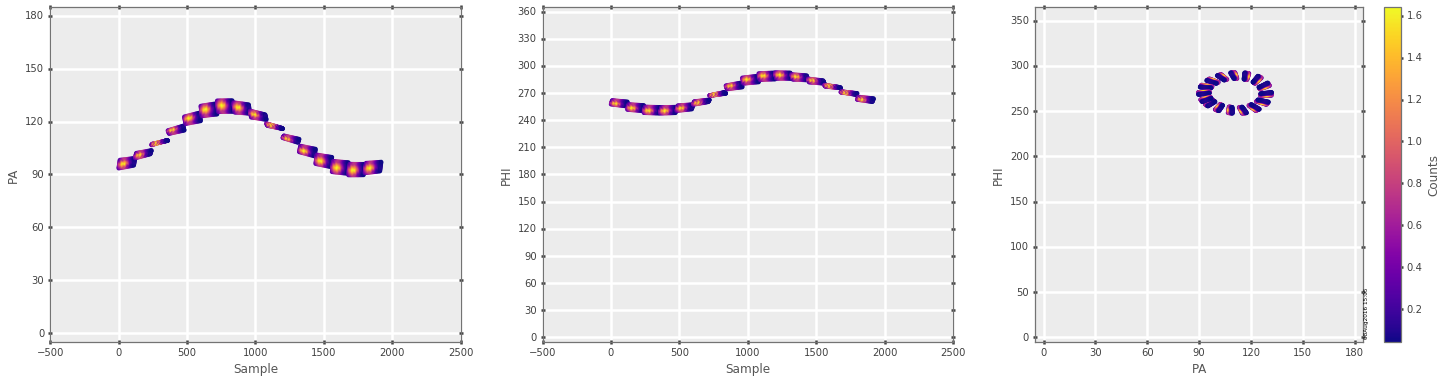

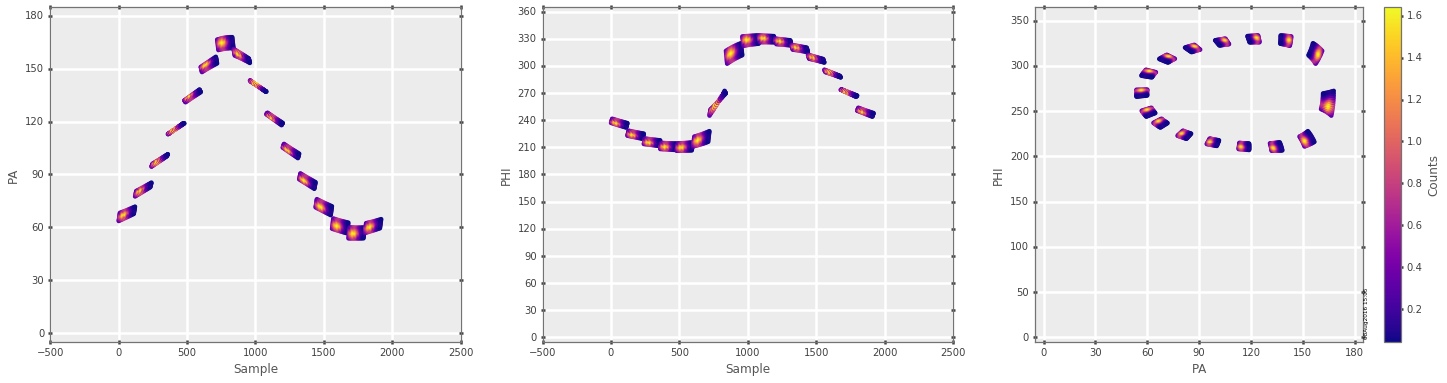

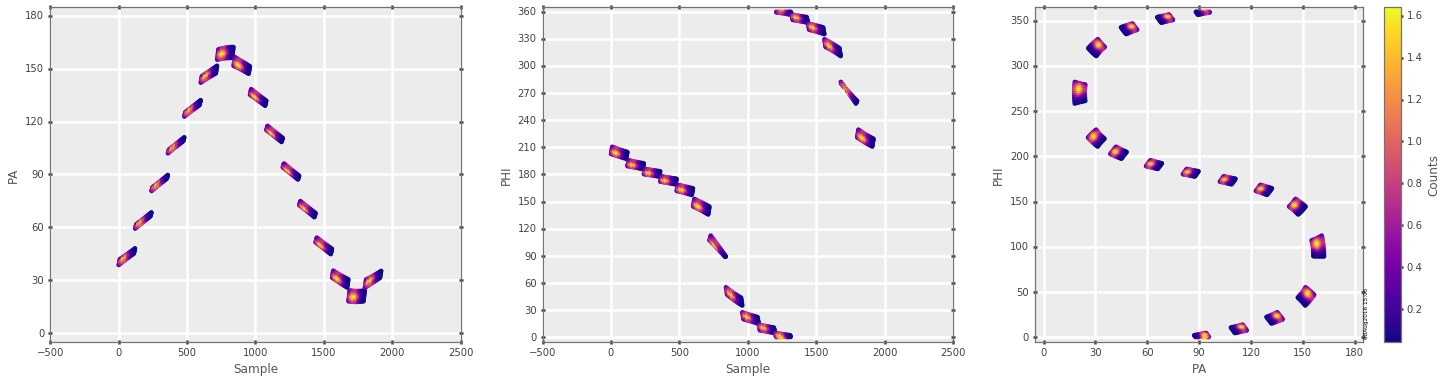

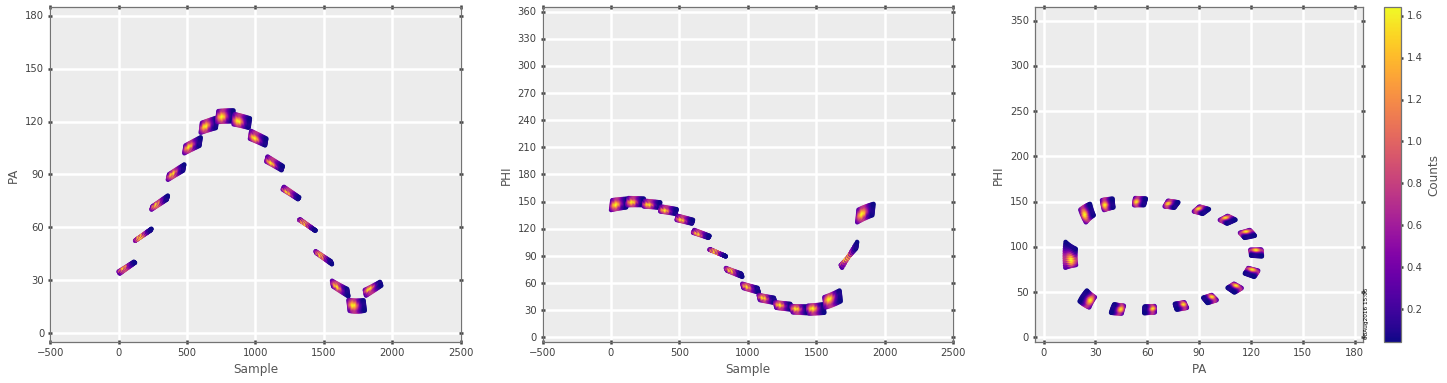

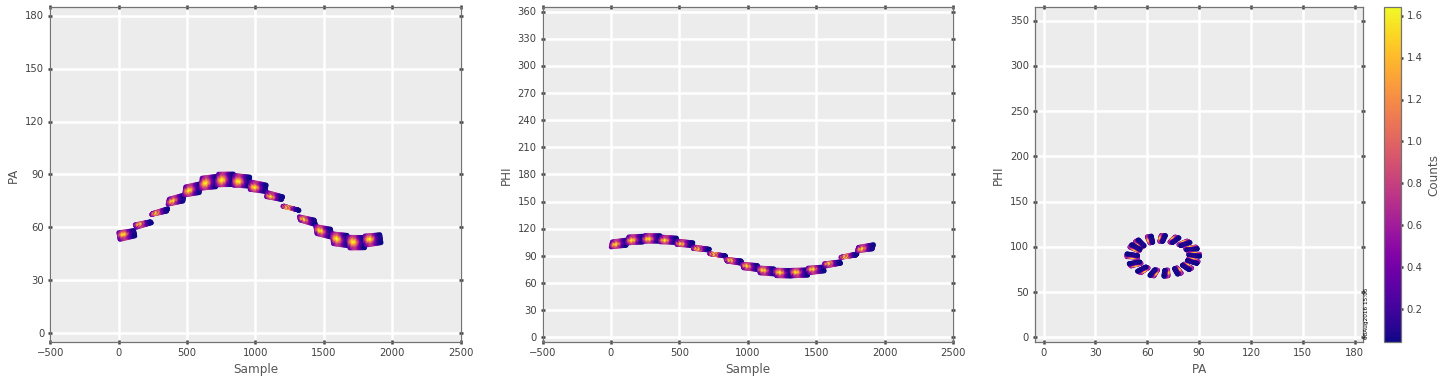

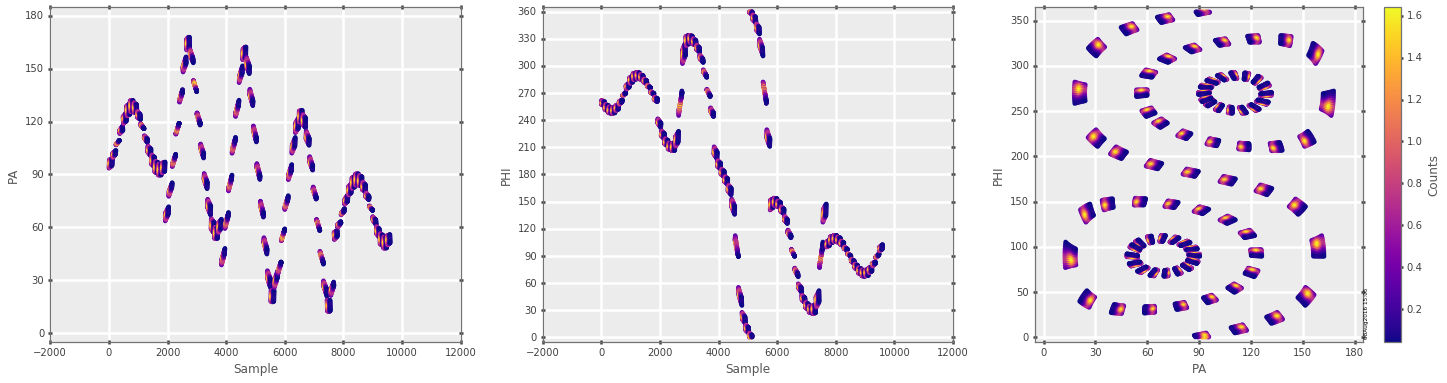

In [5]:
# def make_tagged(countsData, TaggedData, magInterp_Ele, t_proc, lib, energy=32, n_polar=11, n_azi=13, pixel=3):


ans1 = make_tagged(100, TaggedData, magInterp_Ion, (100, 101), lib, pixel=1)
fig = tagged_3plot(ans1)
ans2 = make_tagged(100, TaggedData, magInterp_Ion, (100, 101), lib, pixel=2)
fig = tagged_3plot(ans2)
ans3 = make_tagged(100, TaggedData, magInterp_Ion, (100, 101), lib, pixel=3)
fig = tagged_3plot(ans3)
ans4 = make_tagged(100, TaggedData, magInterp_Ion, (100, 101), lib, pixel=4)
fig = tagged_3plot(ans4)
ans5 = make_tagged(100, TaggedData, magInterp_Ion, (100, 101), lib, pixel=5)
fig = tagged_3plot(ans5)

fig = tagged_3plot(np.vstack((ans1, ans2, ans3, ans4, ans5)))


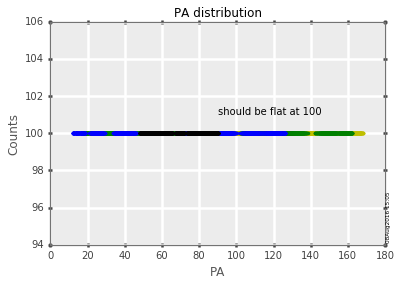

In [6]:
CNTS = ans1[:,2]/ans1[:,3]
plt.plot(ans1[:,0], CNTS, '.r')

CNTS = ans2[:,2]/ans2[:,3]
plt.plot(ans2[:,0], CNTS, '.y')

CNTS = ans3[:,2]/ans3[:,3]
plt.plot(ans3[:,0], CNTS, '.g')

CNTS = ans4[:,2]/ans4[:,3]
plt.plot(ans4[:,0], CNTS, '.b')

CNTS = ans5[:,2]/ans5[:,3]
plt.plot(ans5[:,0], CNTS, '.k')



plt.xlabel('PA')
plt.ylabel('Counts')
plt.title("PA distribution")
plt.text(90, 101, 'should be flat at 100')
spp.timestamp()


# Grab out a time where there are actually counts

In [7]:
import bisect
import datetime

# get the tind
dt = datetime.datetime(2015, 1, 1, 4, 17, 37)
t_ind = bisect.bisect(L1cdf['Epoch_Ion_Cntr_H'], dt)
t_ind = 700 # from below
e_ind = 36
print(L1cdf['ESA_Volt_Ion_Cntr_H'][t_ind][e_ind]*7, t_ind)

(51510.12890625, 700)


## Find times of counts

8225.2802734375

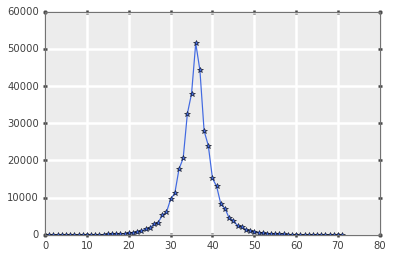

In [8]:
plt.plot(L1cdf['ESA_Volt_Ion_Cntr_H'][0]*7, '*-')
L1cdf['ESA_Volt_Ion_Cntr_H'][0][42]*7


In [9]:
ind = np.zeros((L1cdf['Ion_Cntr_H'].shape[0], len(range(30,43))))
print(ind.shape)
einds = np.asarray(list(range(30,43)))
dat = L1cdf['Ion_Cntr_H'][...][:,2,0,:]

(3469, 13)


1504
(array([   3.,    0.,    1.,  141.,  418.,  230.,    7.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,   12.,   52.,  388.,  434.,  158.,   23.], dtype=float32), (72,))
[  9.80000019e-01   1.19000006e+00   1.81999993e+00   2.17000008e+00
   3.35999990e+00   3.92000008e+00   6.23000002e+00   7.27999973e+00
   1.14799995e+01   1.33699999e+01   2.11399994e+01   2.46399994e+01
   3.89900017e+01   4.55000000e+01   7.19599991e+01   8.37900009e+01
   1.32580002e+02   1.54489990e+02   2.44369995e+02   2.84760010e+02
   4.50449982e+02   5.24860046e+02   8.30270020e+02   9.67399963e

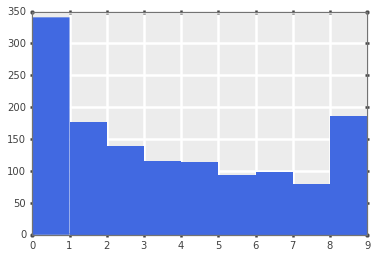

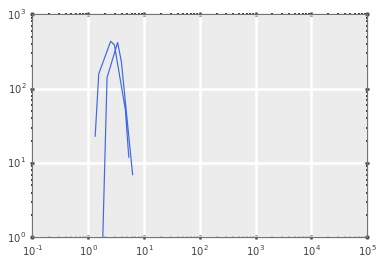

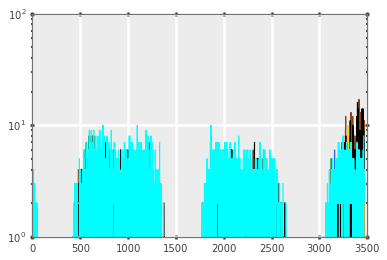

In [10]:
plt.hist(dat.sum(axis=1).flatten(), range(10))
print(np.argmax(dat.sum(axis=1)))
print(dat[1504], dat[1504].shape)
plt.figure()
plt.loglog(L1cdf['ESA_Volt_Ion_Cntr_H'][1504]*7, dat[1504])
print(L1cdf['ESA_Volt_Ion_Cntr_H'][1504]*7)

plt.figure()
plt.semilogy(dat[:,30])
plt.semilogy(dat[:,31])
plt.semilogy(dat[:,32])
plt.semilogy(dat[:,33])
plt.semilogy(dat[:,34])
plt.semilogy(dat[:,35])
plt.semilogy(dat[:,36])



(array([False, False, False, ..., False, False, False], dtype=bool), (3469,))


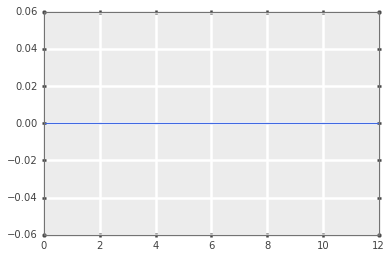

In [11]:

print(dat[:,30] > 20, (dat[:,30] > 20).shape)
for ii, val in enumerate(range(30,43)):
    ind[:,ii] = dat[:,val] > 20 # where do we habe more than 20 counts
plt.plot(ind.sum(axis=0))

In [12]:
l2 = pycdf.CDF(l2cdf)
l2


<CDF:
Acquisition_Period: CDF_REAL4 [7613]
B_Calc_Ele: CDF_REAL4 [4143]
B_Calc_Ion: CDF_REAL4 [3469]
B_Eq_Ele: CDF_REAL4 [4143]
B_Eq_Ion: CDF_REAL4 [3469]
Detector_LABL: CDF_CHAR*2 [5] NRV
ENERGY_Ele_DELTA: CDF_REAL4 [4143, 72]
ENERGY_Ion_DELTA: CDF_REAL4 [3469, 72]
ESA_Polarity: CDF_UINT1 [7613]
ESA_Sweep: CDF_UINT1 [7613]
ESA_Volt: CDF_REAL4 [7613, 72]
ESA_Volt_LABL_1: CDF_CHAR*7 [72] NRV
Energy_Collapsed: CDF_UINT1 [7613]
Energy_LABL: CDF_CHAR*3 [72] NRV
Epoch: CDF_EPOCH [7613]
Epoch_Ele: CDF_EPOCH [4143]
Epoch_Ele_DELTA: CDF_REAL4 [4143]
Epoch_Ion: CDF_EPOCH [3469]
Epoch_Ion_DELTA: CDF_REAL4 [3469]
FEDU: CDF_REAL4 [4143, 5, 16, 72]
FHEDU: CDF_REAL4 [3469, 5, 16, 72]
FLAGS: CDF_CHAR*122 [8] NRV
FODU: CDF_REAL4 [3469, 5, 16, 72]
FPDU: CDF_REAL4 [3469, 5, 16, 72]
Flags_Ele: CDF_UINT1 [4143, 8]
Flags_Ion: CDF_UINT1 [3469, 8]
HOPE_DETECTOR: CDF_INT1 [5] NRV
HOPE_ENERGY_Ele: CDF_REAL4 [4143, 72]
HOPE_ENERGY_Ion: CDF_REAL4 [3469, 72]
HOPE_SECTOR: CDF_INT1 [16] NRV
I_Ele: CDF_REAL4 [4143]


(<Var:
CDF_FLOAT [3469, 5, 16, 72]
>, (3, 16))
[ 1.  2.  2.  3.  4.  4.  6.  4.  4.  1.  0.  2.  3.  3.  5.  1.]
[ 2.  0.  3.  1.  3.  4.  7.  1.  1.  0.  2.  4.  6.  3.  2.  1.]
[ 2.  1.  6.  3.  4.  3.  3.  1.  0.  2.  5.  6.  7.  3.  1.  0.]
[ 1.  2.  2.  3.  4.  4.  6.  4.  4.  1.  0.  2.  3.  3.  5.  1.]


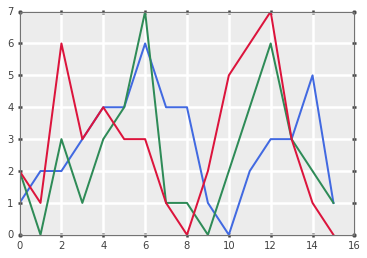

In [13]:
print(L1cdf['Ion_Cntr_H'], L1cdf['Ion_Cntr_H'][t_ind:t_ind+3, 2, :, e_ind].shape)
for v in L1cdf['Ion_Cntr_H'][t_ind:t_ind+3, 2, :, e_ind]:
    print(v)
    plt.plot(v, lw=2)
    

plt.figure()
print(L1cdf['Ion_Cntr_H'][t_ind, 2, :, e_ind])

pixel1
2015-01-01T04:46:34.222000 ...100%

pixel2
2015-01-01T04:46:34.222000 ...100%

pixel3
2015-01-01T04:46:34.222000 ...100%

pixel4
2015-01-01T04:46:34.222000 ...100%

pixel5
2015-01-01T04:46:34.222000 ...100%



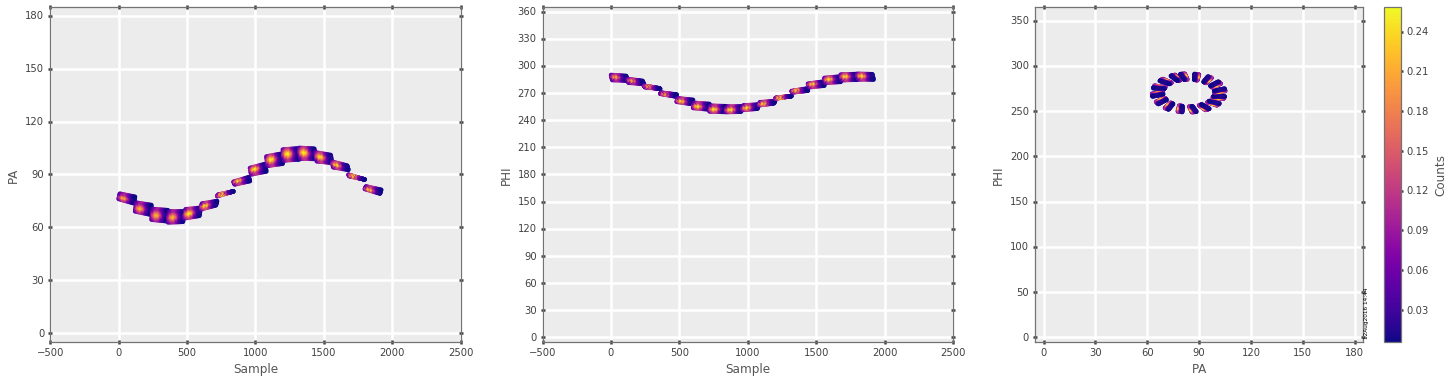

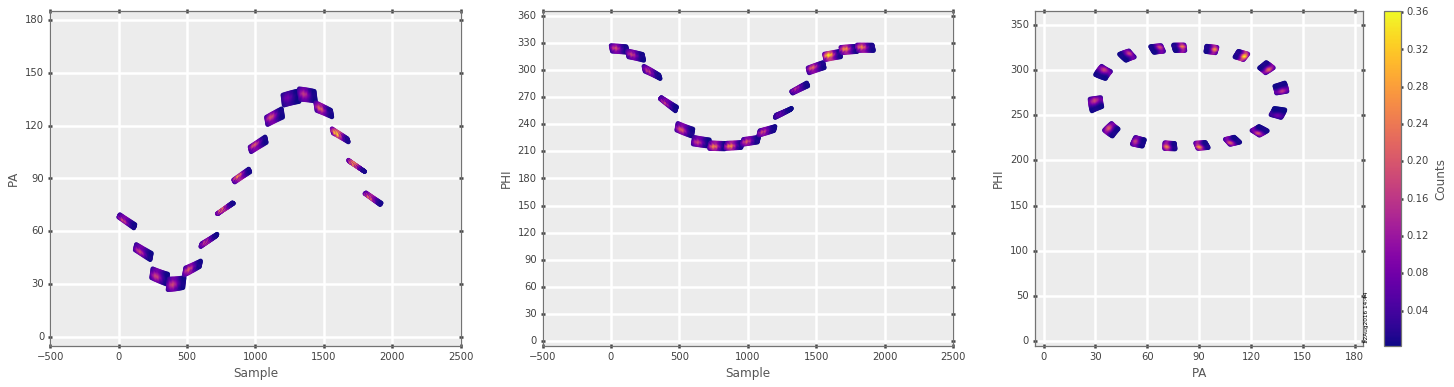

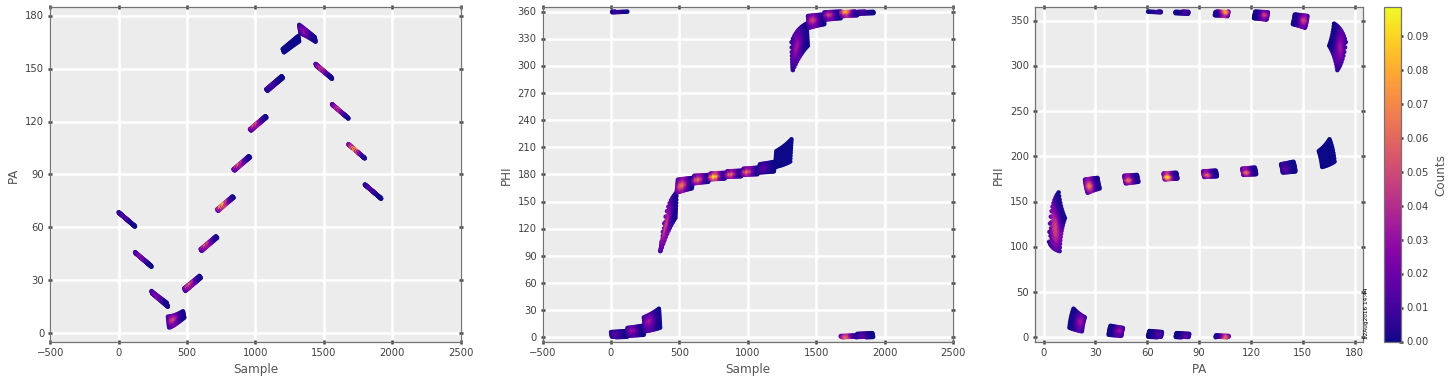

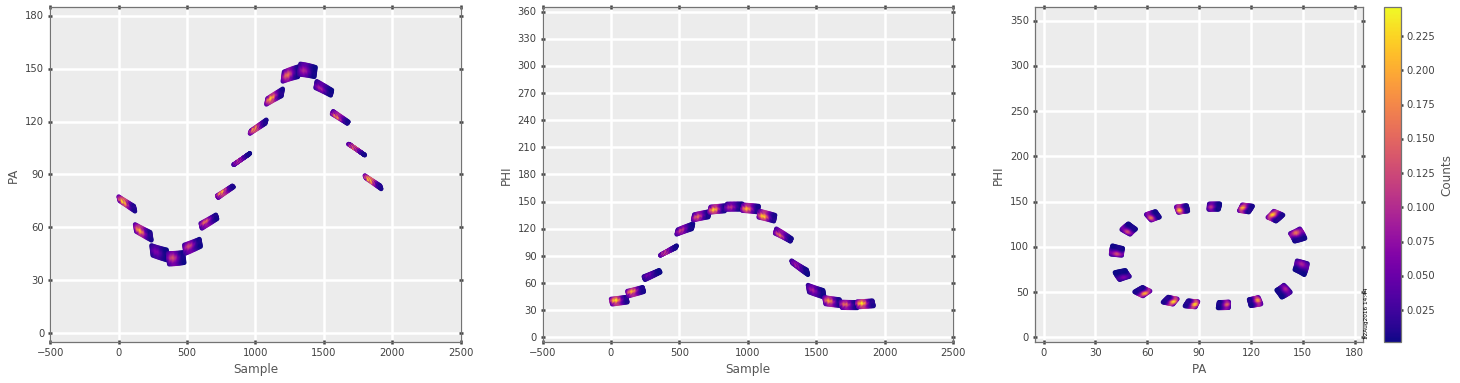

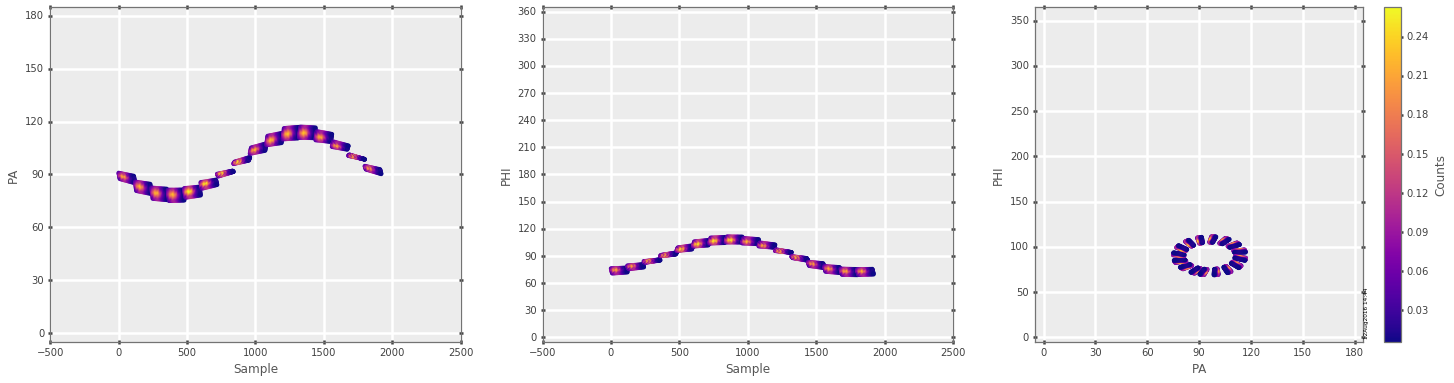

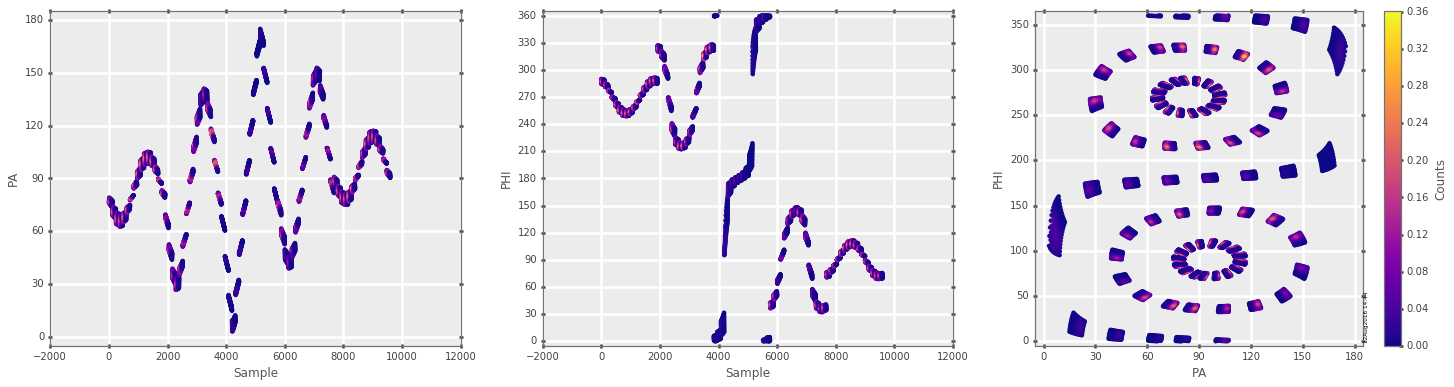

In [19]:
# def make_tagged(countsData, TaggedData, magInterp_Ele, t_proc, lib, energy=32, n_polar=11, n_azi=13, pixel=3):

n_spins = 1

print('pixel1')
ans1 = make_tagged(l1['Ion_Cntr_H'], TaggedData, magInterp_Ele, (t_ind, t_ind+n_spins), lib, pixel=1, energy=e_ind)
fig = tagged_3plot(ans1)
print('pixel2')
ans2 = make_tagged(l1['Ion_Cntr_H'], TaggedData, magInterp_Ele, (t_ind, t_ind+n_spins), lib, pixel=2, energy=e_ind)
fig = tagged_3plot(ans2)
print('pixel3')
ans3 = make_tagged(l1['Ion_Cntr_H'], TaggedData, magInterp_Ele, (t_ind, t_ind+n_spins), lib, pixel=3, energy=e_ind)
fig = tagged_3plot(ans3)
print('pixel4')
ans4 = make_tagged(l1['Ion_Cntr_H'], TaggedData, magInterp_Ele, (t_ind, t_ind+n_spins), lib, pixel=4, energy=e_ind)
fig = tagged_3plot(ans4)
print('pixel5')
ans5 = make_tagged(l1['Ion_Cntr_H'], TaggedData, magInterp_Ele, (t_ind, t_ind+n_spins), lib, pixel=5, energy=e_ind)
fig = tagged_3plot(ans5)

fig = tagged_3plot(np.vstack((ans1, ans2, ans3, ans4, ans5)))


('ans_all', (96000, 4))
(array([ 77,  77,  77, ..., 108, 109, 109]), 21840)


/Users/blarsen/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:49: RuntimeWarning: invalid value encountered in divide


('outC.shape', (180, 5))


/Users/blarsen/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: invalid value encountered in divide


/Users/blarsen/miniconda3/envs/python2/lib/python2.7/site-packages/matplotlib/scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


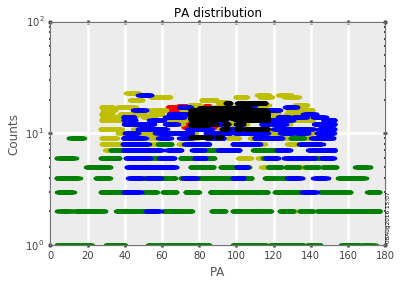

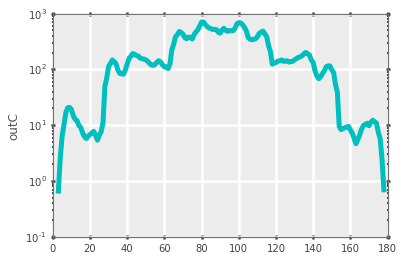

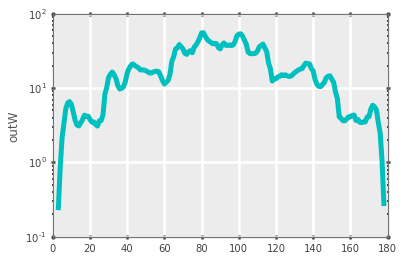

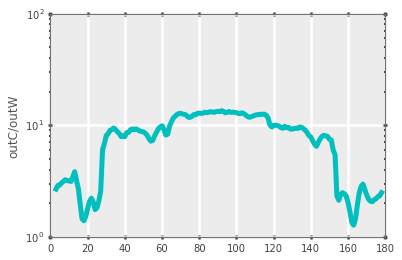

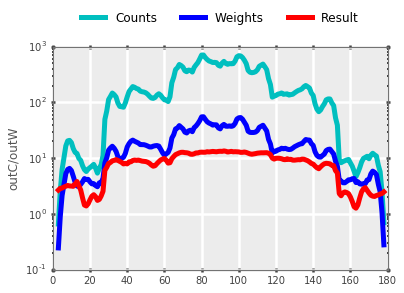

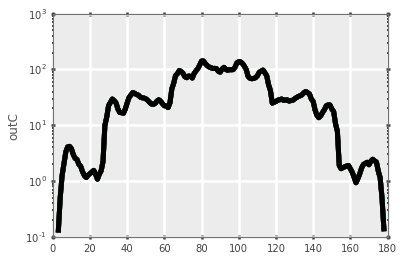

In [15]:
plt.figure()
CNTS = ans1[:,2]/ans1[:,3]
plt.semilogy(ans1[:,0], CNTS, '.r')

CNTS = ans2[:,2]/ans2[:,3]
plt.semilogy(ans2[:,0], CNTS, '.y')

CNTS = ans3[:,2]/ans3[:,3]
plt.semilogy(ans3[:,0], CNTS, '.g')

CNTS = ans4[:,2]/ans4[:,3]
plt.semilogy(ans4[:,0], CNTS, '.b')

CNTS = ans5[:,2]/ans5[:,3]
plt.semilogy(ans5[:,0], CNTS, '.k')


plt.xlabel('PA')
plt.ylabel('Counts')
plt.title("PA distribution")
spp.timestamp()


ans_all = np.vstack((ans1, ans2, ans3, ans4, ans5))
digs = np.digitize(ans_all[:,0], np.arange(181))

print('ans_all', ans_all.shape)

print(digs, digs[digs==60].sum())

outC = np.zeros((180, 5), dtype=float)
outW = np.zeros((180, 5), dtype=float)
for pix in range(1,6):
    for d in np.arange(180):
        ind = (digs == d)
        #         print(d, sum(ind))
        outC[d] = np.sum(ans_all[:,2][ind])
        outW[d] = np.sum(ans_all[:,3][ind])
        
        
plt.figure()

plt.semilogy(np.arange(180), outC.sum(axis=1), lw=5, c='c')
plt.ylabel('outC')
plt.figure()
plt.semilogy(np.arange(180), outW.sum(axis=1), lw=5, c='c')
plt.ylabel('outW')
plt.figure()
plt.semilogy(np.arange(180), outC.sum(axis=1)/outW.sum(axis=1), lw=5, c='c')
plt.ylabel('outC/outW')


print('outC.shape', outC.shape)

plt.figure()
plt.semilogy(np.arange(180), outC.sum(axis=1), lw=5, c='c', label='Counts')
plt.ylabel('outC')
plt.semilogy(np.arange(180), outW.sum(axis=1), lw=5, c='b', label='Weights')
plt.ylabel('outW')
plt.semilogy(np.arange(180), outC.sum(axis=1)/outW.sum(axis=1), lw=5, c='r', label='Result')
plt.ylabel('outC/outW')
ax = plt.gca()
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)


plt.figure()
plt.semilogy(np.arange(180), outC[:,0], lw=5, c='r', label='Counts')
plt.semilogy(np.arange(180), outC[:,1], lw=5, c='y', label='Counts')
plt.semilogy(np.arange(180), outC[:,2], lw=5, c='b', label='Counts')
plt.semilogy(np.arange(180), outC[:,3], lw=5, c='g', label='Counts')
plt.semilogy(np.arange(180), outC[:,4], lw=5, c='k', label='Counts')
plt.ylabel('outC')




# Can we do all this without splitting up the FOV?


In [16]:
# def make_tagged(countsData, TaggedData, magInterp_Ele, t_proc, lib, energy=32, n_polar=11, n_azi=13, pixel=3):

n_spins = 10

print('pixel1')
ans1 = make_tagged(l1['Ion_Cntr_H'], TaggedData, magInterp_Ele, (t_ind, t_ind+n_spins), lib, pixel=1, energy=e_ind, n_polar=1, n_azi=1)
fig = tagged_3plot(ans1)
print('pixel2')
ans2 = make_tagged(l1['Ion_Cntr_H'], TaggedData, magInterp_Ele, (t_ind, t_ind+n_spins), lib, pixel=2, energy=e_ind, n_polar=1, n_azi=1)
fig = tagged_3plot(ans2)
print('pixel3')
ans3 = make_tagged(l1['Ion_Cntr_H'], TaggedData, magInterp_Ele, (t_ind, t_ind+n_spins), lib, pixel=3, energy=e_ind, n_polar=1, n_azi=1)
fig = tagged_3plot(ans3)
print('pixel4')
ans4 = make_tagged(l1['Ion_Cntr_H'], TaggedData, magInterp_Ele, (t_ind, t_ind+n_spins), lib, pixel=4, energy=e_ind, n_polar=1, n_azi=1)
fig = tagged_3plot(ans4)
print('pixel5')
ans5 = make_tagged(l1['Ion_Cntr_H'], TaggedData, magInterp_Ele, (t_ind, t_ind+n_spins), lib, pixel=5, energy=e_ind, n_polar=1, n_azi=1)
fig = tagged_3plot(ans5)

fig = tagged_3plot(np.vstack((ans1, ans2, ans3, ans4, ans5)))


pixel1
2015-01-01T04:46:34.222000 ...10%

IndexError: too many indices for array